In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

/home/dennis00/anaconda3/envs/scRNA-GAN-TF/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [1]:

import scanpy as sc
import matplotlib.pyplot as plt
import scrublet as scr
import numpy as np
import h5py
from scipy.sparse import csc_matrix


In [4]:
h5_file = h5py.File("../ZafrensData/zel031/rnaseq/4020_4021_cens_ambientRNA.h5", "r")

data     = h5_file["/matrix/data"]
genes    = h5_file["/matrix/features/name"]
barcodes = h5_file["/matrix/barcodes"]


genes_names_list    = [name.decode('utf-8') for name in genes]
barcodes_names_list = [name.decode('utf-8') for name in barcodes]

matrix_shape = h5_file["matrix/shape"][:]  # shape = [n_cells, n_features]
print("Matrix shape:", matrix_shape)

# Access the data
data = h5_file["matrix/data"][:]
print("Number of non-zero values:", len(data))

# Access other components of the sparse matrix
indices = h5_file["matrix/indices"][:]
indptr = h5_file["matrix/indptr"][:]

# Construct the sparse matrix
sparse_matrix = csc_matrix((data, indices, indptr), shape=matrix_shape)

# Optionally convert to a dense matrix (be cautious if the matrix is large)
dense_matrix = sparse_matrix.toarray()
csr_matrix_transposed = sparse_matrix.transpose().tocsr()


adata = sc.AnnData(X=csr_matrix_transposed)
adata.obs_names = barcodes_names_list  # Row names (cells)
adata.var_names = genes_names_list     # Column names (features/genes)

scRNA_Seq_original = sc.read_h5ad("../ZafrensData/zel031/rnaseq/4020_4021_cens.h5ad")
adata.obs = scRNA_Seq_original.obs

adata.write("../ZafrensData/zel031/rnaseq/4020_4021_cens_QC_ready.h5ad")


Matrix shape: [36601 63915]
Number of non-zero values: 213304917


/tmp/ipykernel_69566/2993102044.py:30: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=csr_matrix_transposed)


## Handover to QC

In [5]:
scRNA_Seq = adata

### Add var elements for mitochondrial, ribosomal and haemoglobin genes

In [6]:

scRNA_Seq.var["mt"] = scRNA_Seq.var_names.str.startswith("MT-")
scRNA_Seq.var["ribo"] = scRNA_Seq.var_names.str.startswith(("RPS", "RPL"))
scRNA_Seq.var["hb"] = scRNA_Seq.var_names.str.contains("^HB[^(P)]")


In [7]:

sc.pp.calculate_qc_metrics(
    scRNA_Seq, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)


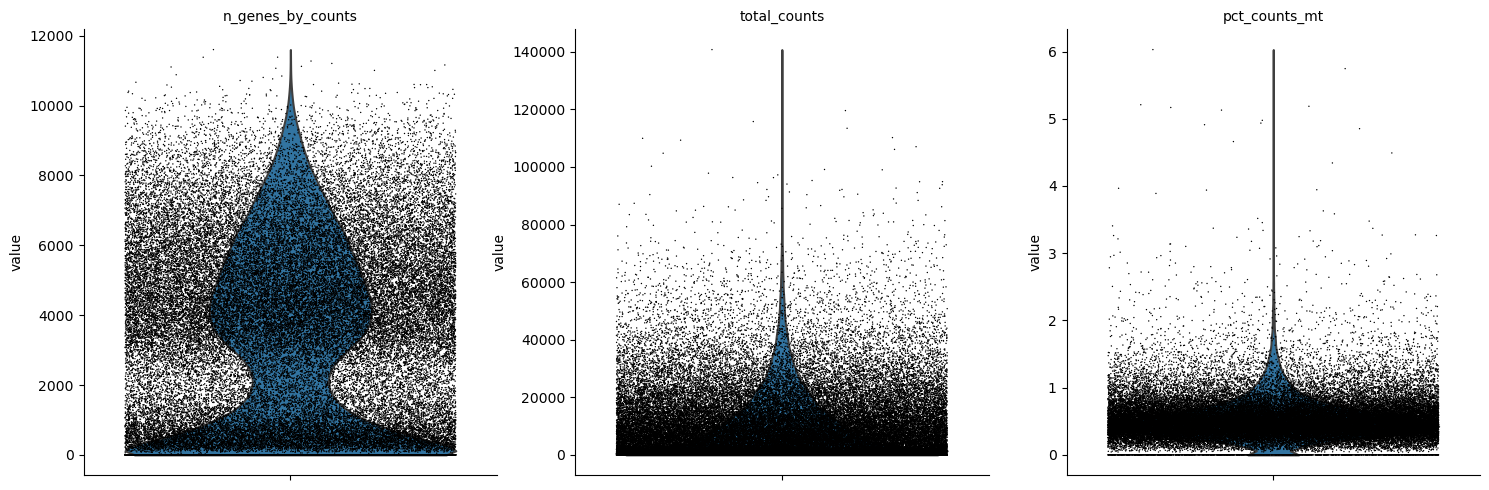

In [8]:

sc.pl.violin(
    scRNA_Seq,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [9]:

scRNA_Seq = scRNA_Seq[scRNA_Seq.obs['pct_counts_mt'] <= 5, :]


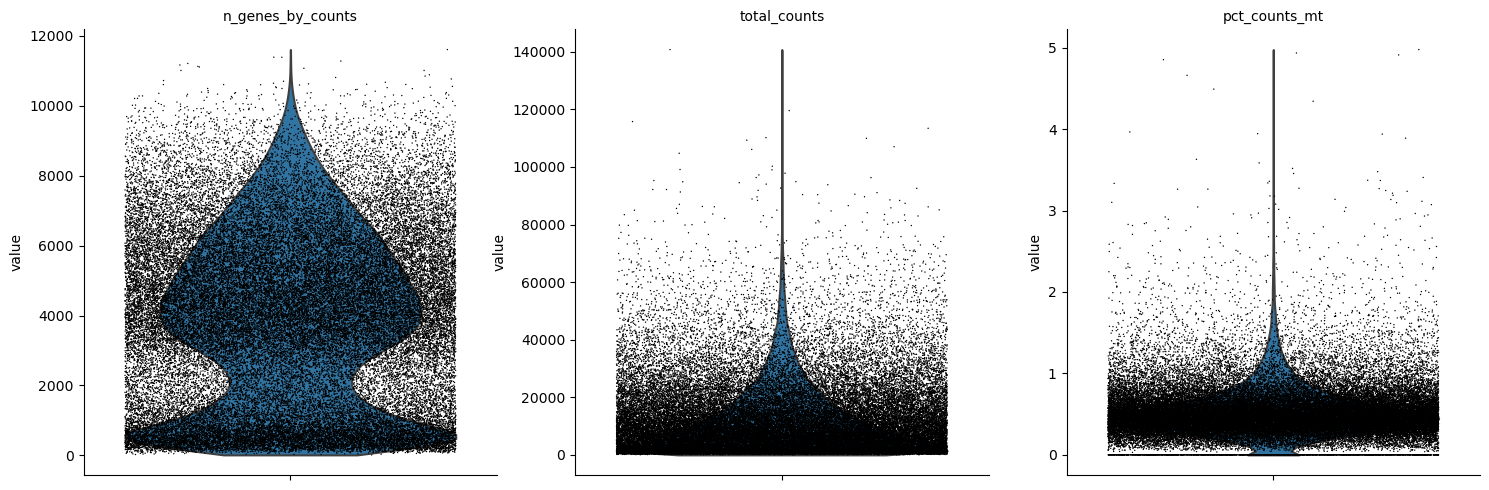

In [10]:

sc.pl.violin(
    scRNA_Seq,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


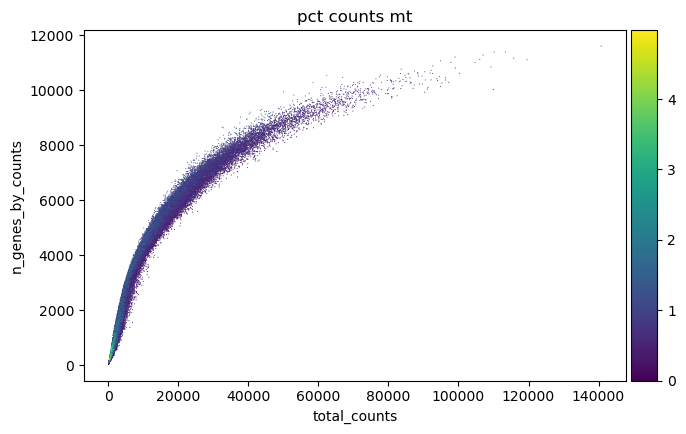

In [11]:

sc.pl.scatter(scRNA_Seq, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


In [12]:
sc.pp.filter_cells(scRNA_Seq, min_genes=100)
sc.pp.filter_genes(scRNA_Seq, min_cells=3)

/home/dennis00/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [13]:
count_matrix = scRNA_Seq.X

In [14]:
scRNA_Seq.obs

device_id sample_id  control_rx_id residual_linker  bb1_id  bb2_id  \
0-0           4020         0             -1             CH3     720    1069   
0-1           4020         0             -1             CH3     170     910   
0-2           4020         0             -1             CH3     710     290   
0-3           4020         0             -1             CH3     611     927   
0-4           4020         0             -1              -1      -1      -1   
...            ...       ...            ...             ...     ...     ...   
15-3040       4021        15             -1              -1      -1      -1   
15-3041       4021        15             -1             CH3     621     887   
15-3042       4021        15             -1             CH3     680     887   
15-3043       4021        15             -1              -1      -1      -1   
15-3044       4021        15             -1             CH3     707    1052   

         censored  n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
0-0         False                559                 6.327937        1402.0   
0-1         False               3820                 8.248267        8656.0   
0-2         False               2825                 7.946618        5804.0   
0-3         False                349                 5.857933         968.0   
0-4          True               3359                 8.119696        6869.0   
...           ...                ...                      ...           ...   
15-3040      True               7815                 8.963928       38642.0   
15-3041     False               3601                 8.189245        8250.0   
15-3042     False                496                 6.208590        1197.0   
15-3043      True               1735                 7.459339        3690.0   
15-3044     False                262                 5.572154         660.0   

         ...  total_counts_mt  log1p_total_counts_mt  pct_counts_mt  \
0-0      ...             10.0               2.397895       0.713267   
0-1      ...             31.0               3.465736       0.358133   
0-2      ...             13.0               2.639057       0.223983   
0-3      ...              2.0               1.098612       0.206612   
0-4      ...             30.0               3.433987       0.436745   
...      ...              ...                    ...            ...   
15-3040  ...            245.0               5.505332       0.634025   
15-3041  ...             46.0               3.850148       0.557576   
15-3042  ...              5.0               1.791759       0.417711   
15-3043  ...             15.0               2.772589       0.406504   
15-3044  ...              1.0               0.693147       0.151515   

         total_counts_ribo  log1p_total_counts_ribo  pct_counts_ribo  \
0-0                  658.0                 6.490724        46.932953   
0-1                 2077.0                 7.639161        23.994917   
0-2                 1546.0                 7.344073        26.636803   
0-3                  531.0                 6.276643        54.855370   
0-4                 1753.0                 7.469654        25.520452   
...                    ...                      ...              ...   
15-3040             8130.0                 9.003439        21.039284   
15-3041             2102.0                 7.651120        25.478788   
15-3042              561.0                 6.331502        46.867168   
15-3043             1081.0                 6.986567        29.295393   
15-3044              412.0                 6.023448        62.424244   

         total_counts_hb  log1p_total_counts_hb  pct_counts_hb  n_genes  
0-0                  0.0               0.000000       0.000000      559  
0-1                  4.0               1.609438       0.046211     3820  
0-2                  1.0               0.693147       0.017229     2825  
0-3                  0.0               0.000000       0.000000      349  
0-4                  2.

In [15]:
# Import Pandas if needed (Scanpy uses it internally)

# Columns to concatenate
columns_to_concat = ['device_id', 'control_rx_id', 'bb1_id', 'bb2_id', 'censored']

# Concatenate columns with an underscore separator
scRNA_Seq.obs['sample'] = scRNA_Seq.obs[columns_to_concat].astype(str).agg('_'.join, axis=1)

# View the new column
print(scRNA_Seq.obs[['sample']].head())


                     sample
0-0  4020_-1_720_1069_False
0-1   4020_-1_170_910_False
0-2   4020_-1_710_290_False
0-3   4020_-1_611_927_False
0-4      4020_-1_-1_-1_True


In [16]:

# Assuming 'adata' is your AnnData object
summary = scRNA_Seq.obs['sample'].value_counts()
print(summary)


4021_-1_-1_-1_True        5444
4020_-1_-1_-1_True        5417
4021_-1_287_1079_False      16
4020_-1_286_1078_False      13
4020_-1_286_1012_False      11
                          ... 
4020_-1_720_950_False        1
4020_-1_709_1079_False       1
4020_-1_670_929_False        1
4020_-1_632_969_False        1
4021_-1_150_893_False        1
Name: sample, Length: 17518, dtype: int64


In [17]:
summary.head(50)

4021_-1_-1_-1_True        5444
4020_-1_-1_-1_True        5417
4021_-1_287_1079_False      16
4020_-1_286_1078_False      13
4020_-1_286_1012_False      11
4021_-1_1287_142_False      11
4021_-1_664_986_False       11
4021_-1_1287_870_False      10
4020_-1_684_870_False       10
4020_-1_710_141_False       10
4021_-1_674_954_False       10
4021_-1_719_1012_False      10
4021_-1_668_990_False       10
4021_-1_696_1074_False      10
4020_-1_287_1069_False      10
4021_-1_287_994_False       10
4021_-1_659_925_False        9
4021_-1_680_1028_False       9
4020_-1_688_927_False        9
4020_-1_696_167_False        9
4021_-1_648_872_False        9
4020_-1_287_871_False        9
4021_-1_1022_117_False       9
4020_-1_650_221_False        9
4020_-1_648_954_False        9
4021_-1_623_886_False        9
4021_-1_608_325_False        9
4021_-1_668_871_False        9
4020_-1_646_974_False        9
4021_-1_285_888_False        9
4021_-1_286_927_False        9
4021_-1_286_1012_False       9
4021_-1_

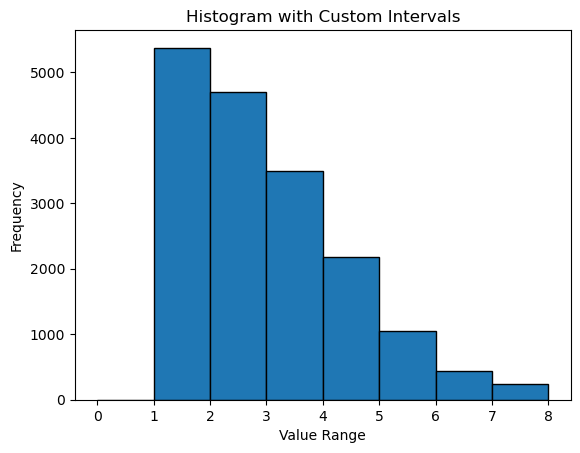

In [18]:

# Sample data
data = summary

# Define custom bins (e.g., intervals 0-5, 5-10, 10-15, 15-20)
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# Plot the histogram with custom intervals
plt.hist(data, bins=bins, edgecolor='black')

# Add labels and title
plt.xlabel('Value Range')
plt.ylabel('Frequency')
plt.title('Histogram with Custom Intervals')

plt.show()


In [19]:
scRNA_Seq.obs

device_id sample_id  control_rx_id residual_linker  bb1_id  bb2_id  \
0-0           4020         0             -1             CH3     720    1069   
0-1           4020         0             -1             CH3     170     910   
0-2           4020         0             -1             CH3     710     290   
0-3           4020         0             -1             CH3     611     927   
0-4           4020         0             -1              -1      -1      -1   
...            ...       ...            ...             ...     ...     ...   
15-3040       4021        15             -1              -1      -1      -1   
15-3041       4021        15             -1             CH3     621     887   
15-3042       4021        15             -1             CH3     680     887   
15-3043       4021        15             -1              -1      -1      -1   
15-3044       4021        15             -1             CH3     707    1052   

         censored  n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
0-0         False                559                 6.327937        1402.0   
0-1         False               3820                 8.248267        8656.0   
0-2         False               2825                 7.946618        5804.0   
0-3         False                349                 5.857933         968.0   
0-4          True               3359                 8.119696        6869.0   
...           ...                ...                      ...           ...   
15-3040      True               7815                 8.963928       38642.0   
15-3041     False               3601                 8.189245        8250.0   
15-3042     False                496                 6.208590        1197.0   
15-3043      True               1735                 7.459339        3690.0   
15-3044     False                262                 5.572154         660.0   

         ...  log1p_total_counts_mt  pct_counts_mt  total_counts_ribo  \
0-0      ...               2.397895       0.713267              658.0   
0-1      ...               3.465736       0.358133             2077.0   
0-2      ...               2.639057       0.223983             1546.0   
0-3      ...               1.098612       0.206612              531.0   
0-4      ...               3.433987       0.436745             1753.0   
...      ...                    ...            ...                ...   
15-3040  ...               5.505332       0.634025             8130.0   
15-3041  ...               3.850148       0.557576             2102.0   
15-3042  ...               1.791759       0.417711              561.0   
15-3043  ...               2.772589       0.406504             1081.0   
15-3044  ...               0.693147       0.151515              412.0   

         log1p_total_counts_ribo  pct_counts_ribo  total_counts_hb  \
0-0                     6.490724        46.932953              0.0   
0-1                     7.639161        23.994917              4.0   
0-2                     7.344073        26.636803              1.0   
0-3                     6.276643        54.855370              0.0   
0-4                     7.469654        25.520452              2.0   
...                          ...              ...              ...   
15-3040                 9.003439        21.039284             10.0   
15-3041                 7.651120        25.478788              0.0   
15-3042                 6.331502        46.867168              0.0   
15-3043                 6.986567        29.295393              0.0   
15-3044                 6.023448        62.424244              0.0   

         log1p_total_counts_hb  pct_counts_hb  n_genes                  sample  
0-0                   0.000000       0.000000      559  4020_-1_720_1069_False  
0-1                   1.609438       0.046211     3820   4020_-1_170_910_False  
0-2                   0.693147       0.017229     2825   4020_-1_710_290_False  
0-3                   0.000000       0.000000      349   4020_-1_611_

In [20]:

# Correct filtering for rows where 'censored' is True
filtered_obs = scRNA_Seq.obs[scRNA_Seq.obs['censored'] == True]

# Display the filtered DataFrame
print(filtered_obs.shape)


(10861, 26)


In [21]:
len(scRNA_Seq.obs['sample'].unique())

17518

In [22]:

# Count cells for each sample
cell_counts_per_sample = scRNA_Seq.obs['sample'].value_counts()

# Print samples with zero or missing cells
empty_samples = cell_counts_per_sample[cell_counts_per_sample == 0]
print("Empty samples:", empty_samples)


Empty samples: Series([], Name: sample, dtype: int64)


In [23]:
print(scRNA_Seq.obs.columns)


Index(['device_id', 'sample_id', 'control_rx_id', 'residual_linker', 'bb1_id',
       'bb2_id', 'censored', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample'],
      dtype='object')


In [24]:

print("Matrix shape:", scRNA_Seq.X.shape)
print("Non-zero entries:", (scRNA_Seq.X != 0).sum())


Matrix shape: (54870, 29101)
Non-zero entries: 213292609


In [25]:
# Initialize Scrublet with the count matrix
scrub = scr.Scrublet(count_matrix)


In [26]:

# Run doublet detection
doublet_scores, predicted_doublets = scrub.scrub_doublets()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.12
Detected doublet rate = 34.6%
Estimated detectable doublet fraction = 61.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 56.5%
Elapsed time: 128.2 seconds


In [27]:

# Add the results to the AnnData object

scRNA_Seq.obs['doublet_score']     = doublet_scores
scRNA_Seq.obs['predicted_doublet'] = predicted_doublets


In [28]:

scRNA_Seq.obs


device_id sample_id  control_rx_id residual_linker  bb1_id  bb2_id  \
0-0           4020         0             -1             CH3     720    1069   
0-1           4020         0             -1             CH3     170     910   
0-2           4020         0             -1             CH3     710     290   
0-3           4020         0             -1             CH3     611     927   
0-4           4020         0             -1              -1      -1      -1   
...            ...       ...            ...             ...     ...     ...   
15-3040       4021        15             -1              -1      -1      -1   
15-3041       4021        15             -1             CH3     621     887   
15-3042       4021        15             -1             CH3     680     887   
15-3043       4021        15             -1              -1      -1      -1   
15-3044       4021        15             -1             CH3     707    1052   

         censored  n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
0-0         False                559                 6.327937        1402.0   
0-1         False               3820                 8.248267        8656.0   
0-2         False               2825                 7.946618        5804.0   
0-3         False                349                 5.857933         968.0   
0-4          True               3359                 8.119696        6869.0   
...           ...                ...                      ...           ...   
15-3040      True               7815                 8.963928       38642.0   
15-3041     False               3601                 8.189245        8250.0   
15-3042     False                496                 6.208590        1197.0   
15-3043      True               1735                 7.459339        3690.0   
15-3044     False                262                 5.572154         660.0   

         ...  total_counts_ribo  log1p_total_counts_ribo  pct_counts_ribo  \
0-0      ...              658.0                 6.490724        46.932953   
0-1      ...             2077.0                 7.639161        23.994917   
0-2      ...             1546.0                 7.344073        26.636803   
0-3      ...              531.0                 6.276643        54.855370   
0-4      ...             1753.0                 7.469654        25.520452   
...      ...                ...                      ...              ...   
15-3040  ...             8130.0                 9.003439        21.039284   
15-3041  ...             2102.0                 7.651120        25.478788   
15-3042  ...              561.0                 6.331502        46.867168   
15-3043  ...             1081.0                 6.986567        29.295393   
15-3044  ...              412.0                 6.023448        62.424244   

         total_counts_hb  log1p_total_counts_hb  pct_counts_hb  n_genes  \
0-0                  0.0               0.000000       0.000000      559   
0-1                  4.0               1.609438       0.046211     3820   
0-2                  1.0               0.693147       0.017229     2825   
0-3                  0.0               0.000000       0.000000      349   
0-4                  2.0               1.098612       0.029116     3359   
...                  ...                    ...            ...      ...   
15-3040             10.0               2.397895       0.025879     7815   
15-3041              0.0               0.000000       0.000000     3601   
15-3042              0.0               0.000000       0.000000      496   
15-3043              0.0               0.000000       0.000000     1735   
15-3044              0.0               0.000000       0.000000      262   

                         sample  doublet_score  predicted_doublet  
0-0      4020_-1_720_1069_False       0.042605              False  
0-1       4020_-1_170_910_False       0.115996              False  
0-2       4020_-1_710_290_False       0.069928              False  
0-3       402

In [29]:

sampled_adata = scRNA_Seq[np.random.choice(scRNA_Seq.obs_names, size=10000, replace=False), :]


/home/dennis00/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


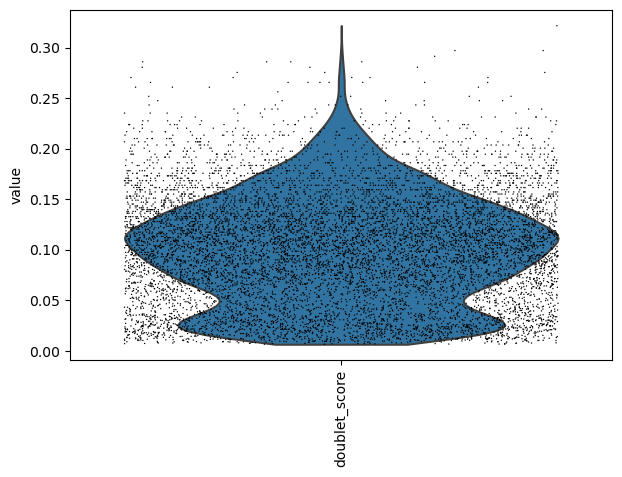

In [30]:

sc.pl.violin(sampled_adata, keys='doublet_score', rotation=90, jitter=0.4)


In [31]:

scRNA_Seq = scRNA_Seq[~scRNA_Seq.obs['predicted_doublet']]


In [32]:

scRNA_Seq.write("../ZafrensData/zel031/rnaseq/4020_4021_cens_final.h5ad")


/home/dennis00/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [2]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [3]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [4]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [9]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr = 0.0002):
        super().__init__()
        self.save_hyperparameters()

        self.automatic_optimization = False

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.validation_z = torch.randn(6, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
    # Access optimizers manually
        opt_g, opt_d = self.optimizers()
    
        real_imgs, _ = batch
    
        # Generate noise and sample fake images
        z = torch.randn(real_imgs.size(0), self.hparams.latent_dim).type_as(real_imgs)
        fake_imgs = self(z)
    
        # -------- Train Generator --------
        # Maximize log(D(G(z)))
        self.toggle_optimizer(opt_g)  # Optional to prevent gradient accumulation from other optimizers
        y_hat = self.discriminator(fake_imgs)
        y = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
    
        g_loss = self.adversarial_loss(y_hat, y)
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
        self.untoggle_optimizer(opt_g)
    
        self.log("g_loss", g_loss, prog_bar=True)
    
        # -------- Train Discriminator --------
        # Maximize log(D(x)) + log(1 - D(G(z)))
        self.toggle_optimizer(opt_d)
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        real_loss = self.adversarial_loss(y_hat_real, y_real)
    
        y_hat_fake = self.discriminator(fake_imgs.detach())
        y_fake = torch.zeros(real_imgs.size(0), 1).type_as(real_imgs)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
    
        d_loss = (real_loss + fake_loss) / 2
        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
        self.untoggle_optimizer(opt_d)
    
        self.log("d_loss", d_loss, prog_bar=True)


    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr = lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr = lr)
        return [opt_g, opt_d], []

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i + 1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap = 'gray_r', interpolation = 'none')
            plt.title("Generated Data")
            plt.xticks()
            plt.yticks()
            plt.axis('off')
        plt.show()
            
    def on_epoch_end(self):
        self.plot_imgs()
        

        

In [10]:
dm = MNISTDataModule()
model = GAN()

epoch 0


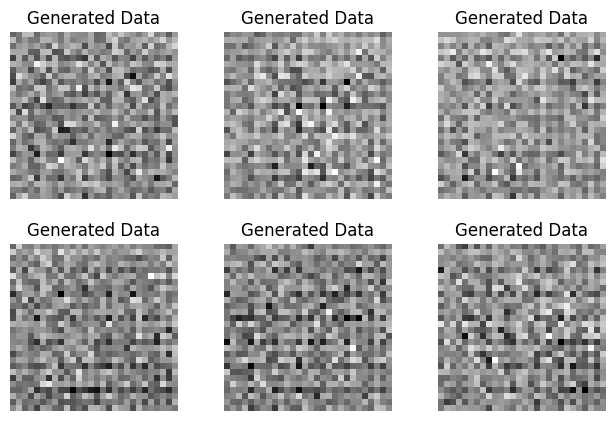

In [11]:
model.plot_imgs()

In [ ]:
trainer = pl.Trainer(max_epochs=20, accelerator="auto")
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…